# Prescribed-Time Heading Controller Demo

This notebook demonstrates the `PrescribedTimeController` which guarantees heading convergence to line-of-sight (LOS) in a prescribed time `tp`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

from colav_controllers import PrescribedTimeController

/home/mstolberger/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## Controller Parameters

- `a`: Heading dynamics coefficient
- `v`: Ship velocity (m/s)
- `eta`: Controller gain (must be > 1)
- `tp`: Prescribed time for heading convergence (seconds)

In [2]:
# Controller parameters
a = 1.0      # Heading dynamics coefficient
v = 2.0      # Ship velocity (m/s)
eta = 2.0    # Controller gain (eta > 1)
tp = 5.0     # Prescribed time (seconds)

controller = PrescribedTimeController(a=a, v=v, eta=eta, tp=tp)

print(f"Controller initialized with tp={tp}s")

Controller initialized with tp=5.0s


## Simulation Setup

Ship starts at origin heading east (ψ=0), waypoint is ahead and to the left.

In [3]:
# Initial state: [x, y, psi]
x0, y0, psi0 = 0.0, 0.0, 0.0  # Start at origin, heading east

# Waypoint position
xw, yw = 50.0, 30.0

# Simulation time
t_span = (0, 30)
t_eval = np.linspace(0, 30, 500)

print(f"Initial position: ({x0}, {y0})")
print(f"Initial heading: {np.degrees(psi0):.1f}°")
print(f"Waypoint: ({xw}, {yw})")

Initial position: (0.0, 0.0)
Initial heading: 0.0°
Waypoint: (50.0, 30.0)


In [4]:
def dynamics(t, state):
    """ODE system for ship dynamics with prescribed-time control."""
    x, y, psi = state
    return controller.compute_dynamics(t, x, y, psi, xw, yw)

# Solve ODE
sol = solve_ivp(dynamics, t_span, [x0, y0, psi0], t_eval=t_eval, method='RK45')

print(f"Simulation complete: {len(sol.t)} time steps")

Simulation complete: 500 time steps


## Results Visualization

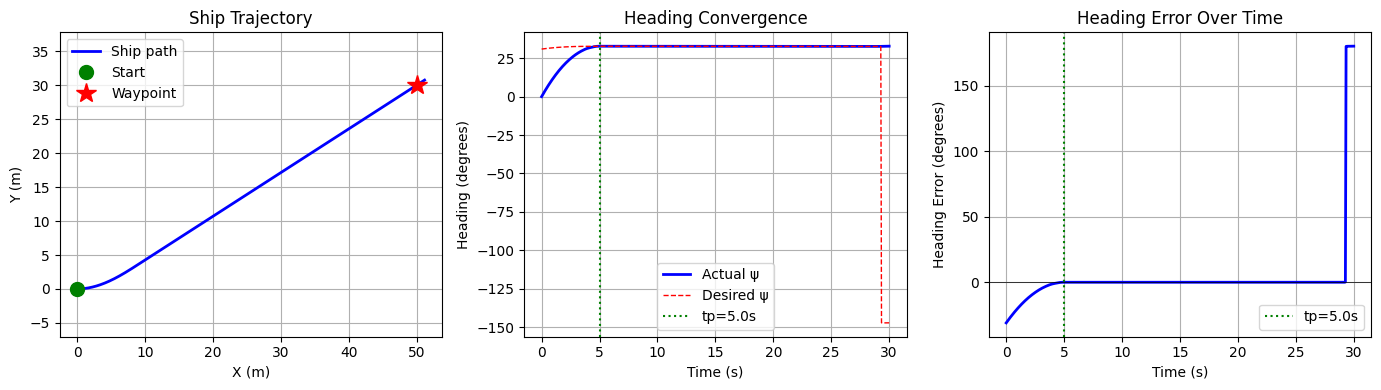

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Plot 1: Trajectory
axes[0].plot(sol.y[0], sol.y[1], 'b-', linewidth=2, label='Ship path')
axes[0].plot(x0, y0, 'go', markersize=10, label='Start')
axes[0].plot(xw, yw, 'r*', markersize=15, label='Waypoint')
axes[0].set_xlabel('X (m)')
axes[0].set_ylabel('Y (m)')
axes[0].set_title('Ship Trajectory')
axes[0].legend()
axes[0].grid(True)
axes[0].axis('equal')

# Plot 2: Heading over time
psi_deg = np.degrees(sol.y[2])
psi_desired = np.degrees(np.arctan2(yw - sol.y[1], xw - sol.y[0]))
axes[1].plot(sol.t, psi_deg, 'b-', linewidth=2, label='Actual ψ')
axes[1].plot(sol.t, psi_desired, 'r--', linewidth=1, label='Desired ψ')
axes[1].axvline(x=tp, color='g', linestyle=':', label=f'tp={tp}s')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Heading (degrees)')
axes[1].set_title('Heading Convergence')
axes[1].legend()
axes[1].grid(True)

# Plot 3: Heading error
heading_error = psi_deg - psi_desired
axes[2].plot(sol.t, heading_error, 'b-', linewidth=2)
axes[2].axvline(x=tp, color='g', linestyle=':', label=f'tp={tp}s')
axes[2].axhline(y=0, color='k', linestyle='-', linewidth=0.5)
axes[2].set_xlabel('Time (s)')
axes[2].set_ylabel('Heading Error (degrees)')
axes[2].set_title('Heading Error Over Time')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

## Verify Prescribed-Time Convergence

The heading error should be near zero by time `tp`.

In [7]:
# Find heading error at t=tp
idx_tp = np.argmin(np.abs(sol.t - tp))
error_at_tp = heading_error[idx_tp]

print(f"Heading error at t={tp}s: {error_at_tp:.2f}°")

Heading error at t=5.0s: 0.04°
